In [1]:
!pip install pgeocode
!pip install pingouin
!conda install -c pyviz hvplot -y
!conda install -y --channel conda-forge geopandas
!conda install -c conda-forge fiona -y



  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::pyls-black==0.4.6=hd3eb1b0_0
  - defaults/linux-64::anaconda==2021.05=py38_0
  - defaults/noarch::python-language-server==0.36.2=pyhd3eb1b0_0
  - defaults/noarch::flake8==3.9.0=pyhd3eb1b0_0
  - defaults/noarch::autopep8==1.5.6=pyhd3eb1b0_0
  - defaults/noarch::pyls-spyder==0.3.2=pyhd3eb1b0_0
  - defaults/linux-64::spyder==4.2.5=py38h06a4308_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Pl

In [2]:
import os


os.environ["DASK_TEMPORARY_DIRECTORY"] = "tmp/dask"
os.environ["PGEOCODE_DATA_DIR"] = "tmp/pgeocode_data"
if not os.path.exists("tmp"):
    os.mkdir("tmp")
if not os.path.exists("tmp/dask"):
    os.mkdir("tmp/dask")
if not os.path.exists("tmp/pgeocode_data"):
    os.mkdir("tmp/pgeocode_data")
import pandas as pd
import hvplot.pandas
import dask
import hvplot.dask
import dask.dataframe as dd
import json
import tqdm
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import pgeocode as geo
import geopandas as gpd
import fiona
import panel as pn
pn.extension(comms="vscode")
from scipy.stats import entropy


ERROR 1: PROJ: proj_create_from_database: Open of /home/bestname/anaconda3/envs/dpg/share/proj failed


In [3]:
!ls data_dpg_testdata/reduced/ 

mapping_article_files.json
mapping_city.json
mapping_geo.json
mapping_refferer.json
mapping_view_files.json
reduced_articles_df_article.csv
reduced_articles_df_external_categories.csv
reduced_articles_df_external_entities.csv
reduced_articles_df_external_topics.csv
reduced_articles_df_fixed_set_sensitive.csv
reduced_articles_df_fixed_set_topics.csv
reduced_articles_df_fixed_set_userneeds.csv
reduced_articles_df_internal_topics.csv
reduced_interactions.csv
reduced_views.csv


In [4]:
DATA_FOLDER = "preflight"

In [5]:
ddf_views = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_views.csv', dtype={
       'GEO_ZIPCODE': object,
       'REFR_MEDIUM': object, 'IS_LOGGED_IN': object, 'file_name': object,
       "privacy_advertising":int,       
       "privacy_analytics":int,       
       "privacy_functional":int,       
       "privacy_geo_location":int,       
       "privacy_marketing":int,       
       "privacy_non-personalised_ads":int,       
       "privacy_personalisation":int,       
       "privacy_social_media":int,       
       "privacy_target_advertising":int,       
       'ARTICLE_ID':"int",
       })
ddf_views["article_id"] = ddf_views["ARTICLE_ID"]
# ddf_views = ddf_views.drop(["ARTICLE_ID"] , axis=1)
ddf_views["DERIVED_TSTAMP"] = dd.to_datetime(ddf_views["DERIVED_TSTAMP"])
ddf_views["hour"] = ddf_views["DERIVED_TSTAMP"].dt.hour
ddf_views["weekday"] = ddf_views["DERIVED_TSTAMP"].dt.weekday
ddf_views["dayofmonth"] = ddf_views["DERIVED_TSTAMP"].dt.day
ddf_views["month"] = ddf_views["DERIVED_TSTAMP"].dt.month
ddf_views = ddf_views.replace("nu.web.advertorial", "nu.web")
ddf_views_unidentified = ddf_views[ddf_views["QUASI_USER_ID"].isna()].copy()
ddf_views = ddf_views[~ddf_views["QUASI_USER_ID"].isna()]
device_counts = ddf_views["APP_ID"].value_counts().compute()
# sample_amount = (device_counts.min()//100000)*100000
sample_amount = device_counts.min()
# sample_amount = 1000000
unique_devices = device_counts.index.unique()
columns_privacy = list(ddf_views.columns[ddf_views.columns.str.startswith("privacy_")].values)
columns_time = ["hour", "weekday", "dayofmonth", "month"]

In [6]:
ddf_views = ddf_views.groupby('APP_ID').apply(lambda df: df.sample(sample_amount if len(df) else 0) , meta=ddf_views.partitions[0]).reset_index(drop=True)
ddf_views = ddf_views.set_index('article_id')
ddf_views

Dask DataFrame Structure:
               APP_ID ARTICLE_ID  DERIVED_TSTAMP GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE REFR_MEDIUM REFR_URLHOST QUASI_USER_ID IS_LOGGED_IN privacy_functional privacy_analytics privacy_target_advertising privacy_personalisation privacy_non-personalised_ads privacy_marketing privacy_social_media privacy_geo_location privacy_advertising file_name   hour weekday dayofmonth  month
npartitions=3                                                                                                                                                                                                                                                                                                                                                                                   
4536           object      int64  datetime64[ns]    int64      object     object      object      object        int64        object       object              int64             int64                      int64                   int64                        int64             int64                int64                int64               int64    object  int64   int64      int64  int64
6198406           ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
6212479           ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
20039404          ...        ...             ...      ...         ...        ...         ...         ...          ...           ...          ...                ...               ...                        ...                     ...                          ...               ...                  ...                  ...                 ...       ...    ...     ...        ...    ...
Dask Name: sort_index, 36 graph layers

In [7]:
DATA_FOLDER_ARTICLES = "reduced"
ddf_article = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_article.csv', dtype={'sub_section': 'object',
       'url': 'object'})
# ddf_article["article_id"] = ddf_article["article_id"]#.astype("object")
ddf_article = ddf_article.set_index('article_id')
ddf_article.index = ddf_article.index.astype('int')
ddf_article

Dask DataFrame Structure:
              cds_content_id  brands   title    text authors     url main_section sub_section num_words num_sentences num_chars first_publication_timestamp categories_generated keywords_curated brand_safety_is_brandsafe brand_safety_confidence file_name
npartitions=1                                                                                                                                                                                                                                                
537071                object  object  object  object  object  object       object      object     int64         int64     int64                     float64               object           object                      bool                 float64     int64
6227202                  ...     ...     ...     ...     ...     ...          ...         ...       ...           ...       ...                         ...                  ...              ...                       ...                     ...       ...
Dask Name: assign_index, 6 graph layers

In [8]:
ddf_article_reduced = ddf_article[["num_words", "num_sentences", "num_chars"]].merge(ddf_views[["APP_ID"]], how='inner', left_index=True, right_index=True)
ddf_article_filtered = ddf_article_reduced[["APP_ID", "num_words", "num_sentences", "num_chars"]].loc[ddf_article_reduced["num_chars"] > 0].persist()
# ddf4_p = ddf_article_filtered.groupby("APP_ID").agg(["mean", "std", "count"]).compute()
ddf_article_filtered

#  Some article ids are not int and lead to TypeError: '<' not supported between instances of 'str' and 'int'

Dask DataFrame Structure:
               APP_ID num_words num_sentences num_chars
npartitions=5                                          
4536           object     int64         int64     int64
537071            ...       ...           ...       ...
...               ...       ...           ...       ...
6227202           ...       ...           ...       ...
20039404          ...       ...           ...       ...
Dask Name: loc-series, 1 graph layer

In [9]:
# factor_1 = ddf4.loc[ddf4["APP_ID"] == "nu.android", "num_words"].compute()
# factor_2 = ddf4.loc[ddf4["APP_ID"] == "nu.web", "num_words"].compute()
# factor_3 = ddf4.loc[ddf4["APP_ID"] == "nu.ios", "num_words"].compute()

In [10]:
# fvalue, pvalue = stats.f_oneway(factor_1, factor_2, factor_3)
# fvalue, pvalue

# Correlation device and length of article
The data of number of characters, sentences and words is not normally distributed. Therefore a non-parametric alternative to ANOVA has been applied, Kruskall Wallis H. The result is a signficant relation between the number of words and device type, but not for the number of characters or number of sentences.

In [11]:
# https://www.reneshbedre.com/blog/anova.html

# get ANOVA table as R like output
df_melt = dd.melt(ddf_article_filtered, id_vars=['APP_ID'], value_vars=["num_words", "num_sentences", "num_chars"]).compute()
df_melt.head()

APP_ID   variable  value
0  nu.android  num_words    177
1      nu.ios  num_words    103
2      nu.web  num_words    539
3      nu.web  num_words   2612
4      nu.ios  num_words   2612

In [12]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_chars"], dv='value', between='APP_ID')

Source  ddof1           H         p-unc
Kruskal  APP_ID      2  210.474582  1.977084e-46

In [13]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_words"], dv='value', between='APP_ID')


Source  ddof1           H         p-unc
Kruskal  APP_ID      2  285.355123  1.086232e-62

In [14]:
pg.kruskal(data=df_melt.loc[df_melt["variable"] == "num_sentences"], dv='value', between='APP_ID')

Source  ddof1          H         p-unc
Kruskal  APP_ID      2  60.234359  8.322907e-14

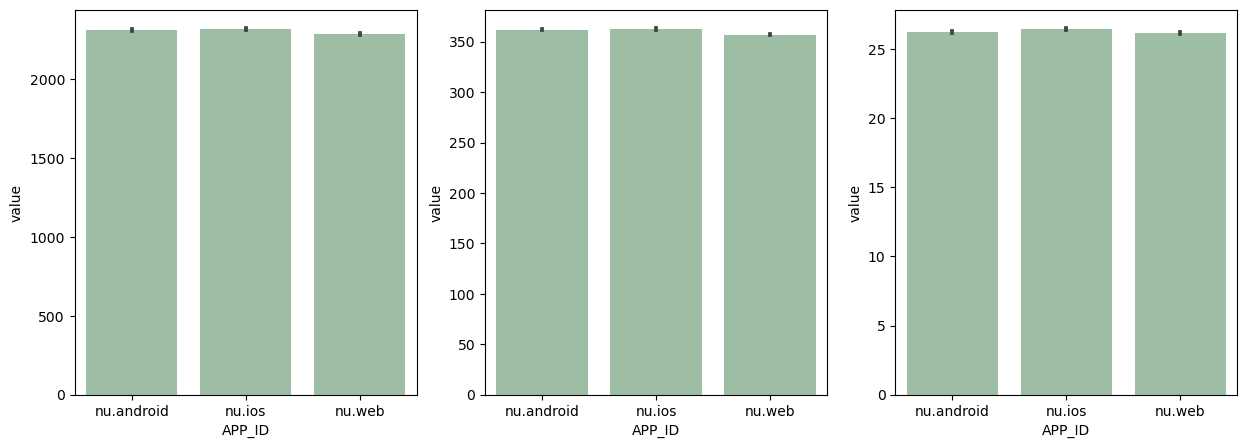

In [15]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
fig, axes= plt.subplots(1, 3, figsize=(15, 5))
with_outliers = True
ax0 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_chars"], color='#99c2a2', ax=axes[0])
ax1 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_words"], color='#99c2a2', ax=axes[1])
ax2 = sns.barplot(x='APP_ID', y='value', data=df_melt.loc[df_melt["variable"] == "num_sentences"], color='#99c2a2', ax=axes[2])
# for ax in [ax0,ax1,ax2]:
#     ax.set_xlim()

plt.show()



In [16]:
ddf3 = ddf_views[[ "APP_ID", "hour"]].compute()
ddf3.head()

APP_ID  hour
article_id                  
4624            nu.web    22
6324            nu.web    17
6324            nu.web    20
6878        nu.android    13
6907            nu.ios    16

# Correlation device and time of day
A graph has been created showing at what time of day interactions took place per device type. The samples taken from each category are equal, since in the dataset nu.web occurs more frequently than nu.ios and nu.android.

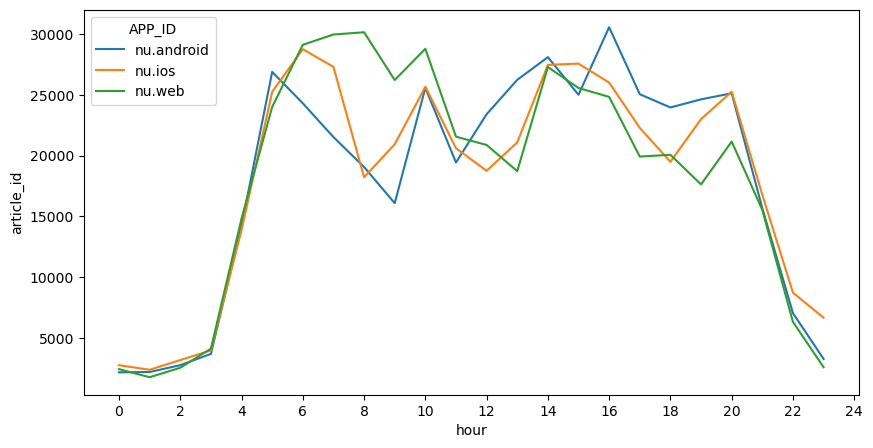

In [17]:
# TODO: Add a normalized graph
stepsize = 2
fig = plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="hour", y="article_id", hue="APP_ID" ,data=ddf3.reset_index().groupby(["APP_ID", "hour"]).agg("count"))
ax.xaxis.set_ticks(np.arange(0, 26, stepsize))
plt.show()

In [18]:

ddf_topics = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_topics.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
topic_columns = ddf_topics.columns[ddf_topics.columns.str.startswith("topic_")].values

ddf_topics = ddf_topics.reset_index().set_index('index')
ddf_topics = ddf_topics.assign(article_topic_entropy = dd.from_array(entropy(ddf_topics[topic_columns], axis=1)))
ddf_topics = ddf_topics.assign(argmax_topic = dd.from_array(ddf_topics[topic_columns].idxmax(axis=1).compute().values))
ddf_topics = ddf_topics.set_index('article_id')

ddf_topics.head()

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
article_id                                                                     
537071           0.001038                           0.000917        0.015824   
962788           0.001125                           0.044565        0.000851   
1013291          0.105175                           0.028085        0.001613   
1149251          0.096021                           0.001019        0.000872   
1401797          0.002146                           0.001896        0.001623   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
article_id                                                           
537071                         0.036879                   0.018781   
962788                         0.043789                   0.002104   
1013291                        0.025450                   0.024846   
1149251                        0.021542                   0.002109   
1401797                        0.002359                   0.004391   

            topic_bestuur_en_organisatie  topic_human_interest  \
article_id                                                       
537071                          0.000950              0.001434   
962788                          0.001030              0.001554   
1013291                         0.001953              0.036237   
1149251                         0.001056              0.011584   
1401797                         0.001965              0.002967   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
article_id                                                         
537071                      0.027416                    0.000666   
962788                      0.161610                    0.000722   
1013291                     0.063389                    0.041297   
1149251                     0.148419                    0.000740   
1401797                     0.001080                    0.022382   

            topic_veiligheid  ...  topic_overheidsbeleid  \
article_id                    ...                          
537071              0.000616  ...               0.022336   
962788              0.000667  ...               0.001130   
1013291             0.001265  ...               0.024950   
1149251             0.000684  ...               0.001159   
1401797             0.001273  ...               0.002157   

            topic_vakbond_club_en_vereniging  topic_religie  \
article_id                                                    
537071                              0.028335       0.000673   
962788                              0.009267       0.000730   
1013291                             0.049110       0.001384   
1149251                             0.014120       0.000748   
1401797                             0.019468       0.001393   

            topic_bouwen_en_wonen  topic_recht_en_justitie  topic_samenleving  \
article_id                                                                      
537071                   0.000609                 0.000758           0.000555   
962788                   0.019392                 0.000822           0.000602   
1013291                  0.001251                 0.001558           0.001142   
1149251                  0.000677                 0.000842           0.000617   
1401797                  0.001259                 0.001567           0.001149   

            topic_woon_en_leefomgeving  file_name  article_topic_entropy  \
article_id                                                                 
537071                        0.036832          3               2.336185   
962788                        0.001987          1               2.428295   
1013291                       0.054470          2               2.660889   
1149251                       0.039665          3               2.116882   
1401797                       0.003774          3               2.471787   

                      argmax_topic  
article_id         

In [19]:
ddf_topics_merged = ddf_topics.merge(ddf_views[["APP_ID"]], how='inner', left_index=True, right_index=True).persist()
# ddf_topics_merged = ddf_topics_merged.reset_index().set_index('index')
# ddf_topics_merged = ddf_topics_merged.assign(argmax_topic = pd.from_array(ddf_topics_merged[topic_columns].idxmax(axis=1).compute().values))
# ddf_topics_merged = ddf_topics_merged.reset_index(drop=True).reset_index()
display(ddf_topics_merged)


Dask DataFrame Structure:
              topic_voetbal topic_optredens_en_voorstellingen topic_politiek topic_technologie_en_handel topic_relatie_en_opvoeden topic_bestuur_en_organisatie topic_human_interest topic_verkeersongevallen topic_nominatie_en_prijzen topic_veiligheid topic_onderwijs topic_maatschappelijke_instellingen topic_economie topic_lokale_evenementen topic_het_weer topic_brand topic_verkeer topic_gezondheid_en_zorg topic_gemeentepolitiek topic_sport topic_kunst_en_cultuur topic_eten_en_drinken topic_natuur topic_duurzaamheid topic_misdaad topic_wielrennen topic_zingeving_en_verhalen topic_afval_en_milieuproblematiek topic_consumeren_en_vrije_tijd topic_overheidsbeleid topic_vakbond_club_en_vereniging topic_religie topic_bouwen_en_wonen topic_recht_en_justitie topic_samenleving topic_woon_en_leefomgeving file_name article_topic_entropy argmax_topic  APP_ID
npartitions=5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
4536                float64                           float64        float64                     float64                   float64                      float64              float64                  float64                    float64          float64         float64                             float64        float64                  float64        float64     float64       float64                  float64                float64     float64                float64               float64      float64            float64       float64          float64                     float64                           float64                        float64               float64                          float64       float64               float64                 float64           float64                    float64     int64               float64       object  object
537071                  ...                               ...            ...                         ...                       ...                          ...                  ...                      ...                        ...              ...             ...                                 ...            ...                      ...            ...         ...           ...                      ...                    ...         ...                    ...                   ...          ...                ...           ...              ...                         ...                               ...                            ...                   ...                              ...           ...                   ...                     ...               ...                        ...       ...                   ...          ...     ...
...                     ...                               ...            ...                         ...                       ...                          ...                  ...                      ...                        ...              ...             ...                                 ...            ...                      ...            ...         ...           ...                      ...                    ...         ...                    ...                   ...          ...                ...           ...             

# Correlation device and topic
For a correlation between device type and topic, only the most prominent topic from the articles has been considered. Kruskal Wallis H reveals a signficant relation between the topics and device type.

3it [00:02,  1.49it/s]


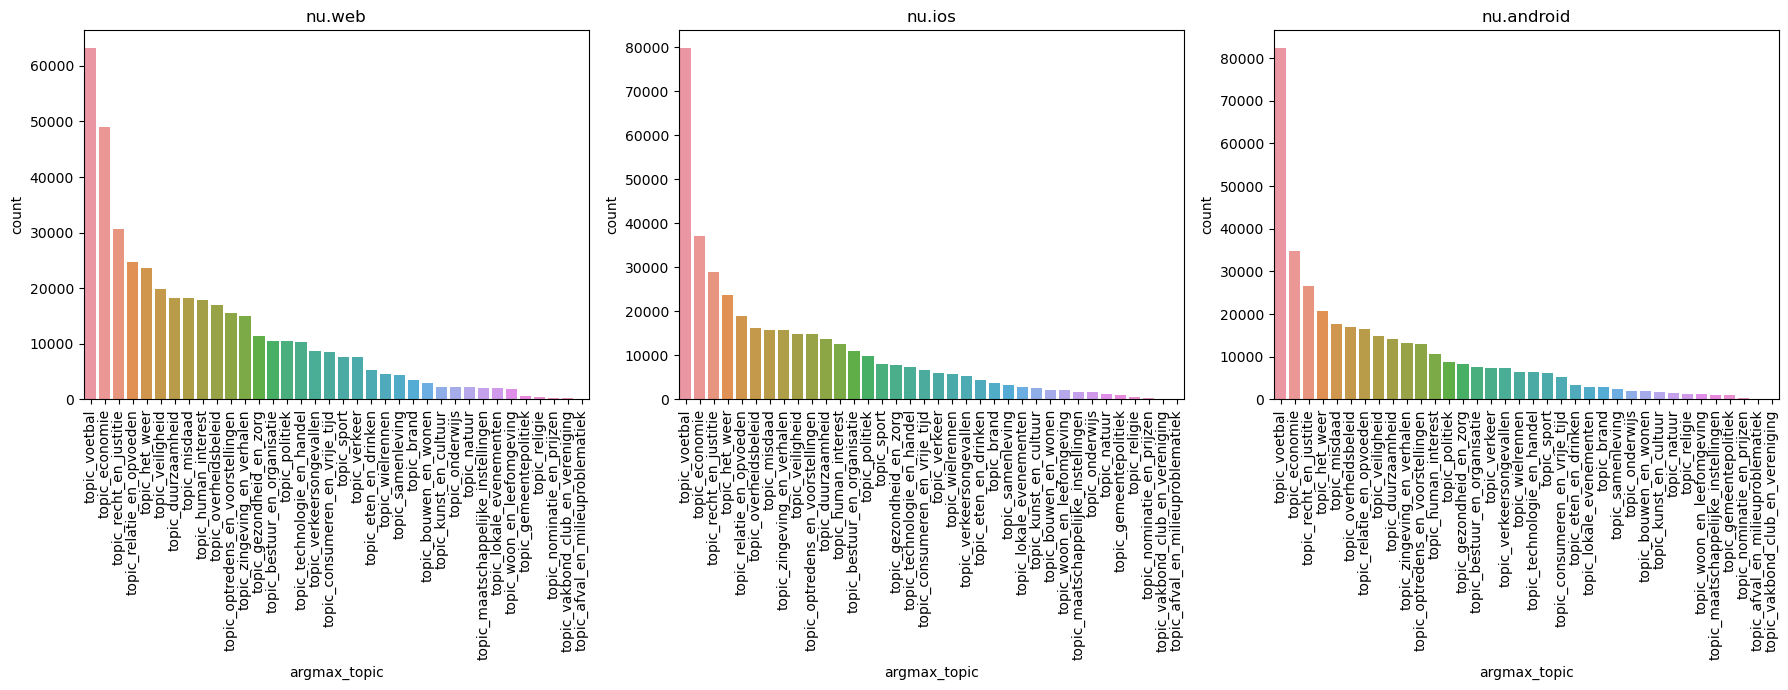

In [20]:
fig, axes = plt.subplots(1,3, figsize=(18, 7))
faxes = axes.flatten()
tmp = ddf_topics_merged[["argmax_topic", "APP_ID"]].compute()
for device, ax in tqdm.tqdm(zip(unique_devices, faxes)):
    order = tmp.loc[tmp["APP_ID"]==device]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["APP_ID"]==device], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(device)
fig.tight_layout()
plt.show()

In [21]:

l_test_results = list()
tmp = ddf_topics_merged.sample(frac=1).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [00:50<00:00,  1.41s/it]


topic  Source  ddof1            H  \
0                         topic_voetbal  APP_ID      2  4089.873353   
32                topic_bouwen_en_wonen  APP_ID      2  1720.348783   
28       topic_consumeren_en_vrije_tijd  APP_ID      2  3400.904506   
23                   topic_duurzaamheid  APP_ID      2  2358.898567   
22                         topic_natuur  APP_ID      2  1888.661383   
21                topic_eten_en_drinken  APP_ID      2  1555.258943   
19                          topic_sport  APP_ID      2  3381.975098   
18               topic_gemeentepolitiek  APP_ID      2  2374.574963   
34                    topic_samenleving  APP_ID      2  1890.509488   
12                       topic_economie  APP_ID      2  3875.510855   
17             topic_gezondheid_en_zorg  APP_ID      2  3361.017453   
35           topic_woon_en_leefomgeving  APP_ID      2  1756.874152   
6                  topic_human_interest  APP_ID      2  2476.994226   
29                topic_overheidsbeleid  APP_ID      2  1257.740848   
2                        topic_politiek  APP_ID      2  1243.967370   
3           topic_technologie_en_handel  APP_ID      2  1052.668707   
11  topic_maatschappelijke_instellingen  APP_ID      2  1050.183217   
9                      topic_veiligheid  APP_ID      2  1037.433865   
4             topic_relatie_en_opvoeden  APP_ID      2   947.957153   
15                          topic_brand  APP_ID      2   869.167233   
10                      topic_onderwijs  APP_ID      2   647.092242   
24                        topic_misdaad  APP_ID      2   645.414099   
1     topic_optredens_en_voorstellingen  APP_ID      2   612.152593   
27    topic_afval_en_milieuproblematiek  APP_ID      2   598.947346   
14                       topic_het_weer  APP_ID      2   496.455742   
25                     topic_wielrennen  APP_ID      2   464.024520   
20               topic_kunst_en_cultuur  APP_ID      2   455.157932   
26          topic_zingeving_en_verhalen  APP_ID      2   454.074857   
16                        topic_verkeer  APP_ID      2   401.418741   
8            topic_nominatie_en_prijzen  APP_ID      2   329.589989   
7              topic_verkeersongevallen  APP_ID      2   300.460783   
5          topic_bestuur_en_organisatie  APP_ID      2   210.272609   
33              topic_recht_en_justitie  APP_ID      2   192.879321   
30     topic_vakbond_club_en_vereniging  APP_ID      2   187.337275   
31                        topic_religie  APP_ID      2   185.917372   
13             topic_lokale_evenementen  APP_ID      2   113.361476   

            p-unc  
0    0.000000e+00  
32   0.000000e+00  
28   0.000000e+00  
23   0.000000e+00  
22   0.000000e+00  
21   0.000000e+00  
19   0.000000e+00  
18   0.000000e+00  
34   0.000000e+00  
12   0.000000e+00  
17   0.000000e+00  
35   0.000000e+00  
6    0.000000e+00  
29  7.674410e-274  
2   7.514804e-271  
3   2.605522e-229  
11  9.028422e-229  
9   5.297836e-226  
4   1.424688e-206  
15  1.831190e-189  
10  3.059885e-141  
24  7.081238e-141  
1   1.182370e-133  
27  8.714377e-131  
14  1.570382e-108  
25  1.731234e-101  
20   1.457843e-99  
26   2.505519e-99  
16   6.808131e-88  
8    2.694284e-72  
7    5.698623e-66  
5    2.187173e-46  
33   1.308542e-42  
30   2.090391e-41  
31   4.251632e-41  
13   2.420295e-25

100%|██████████| 36/36 [00:02<00:00, 12.17it/s]


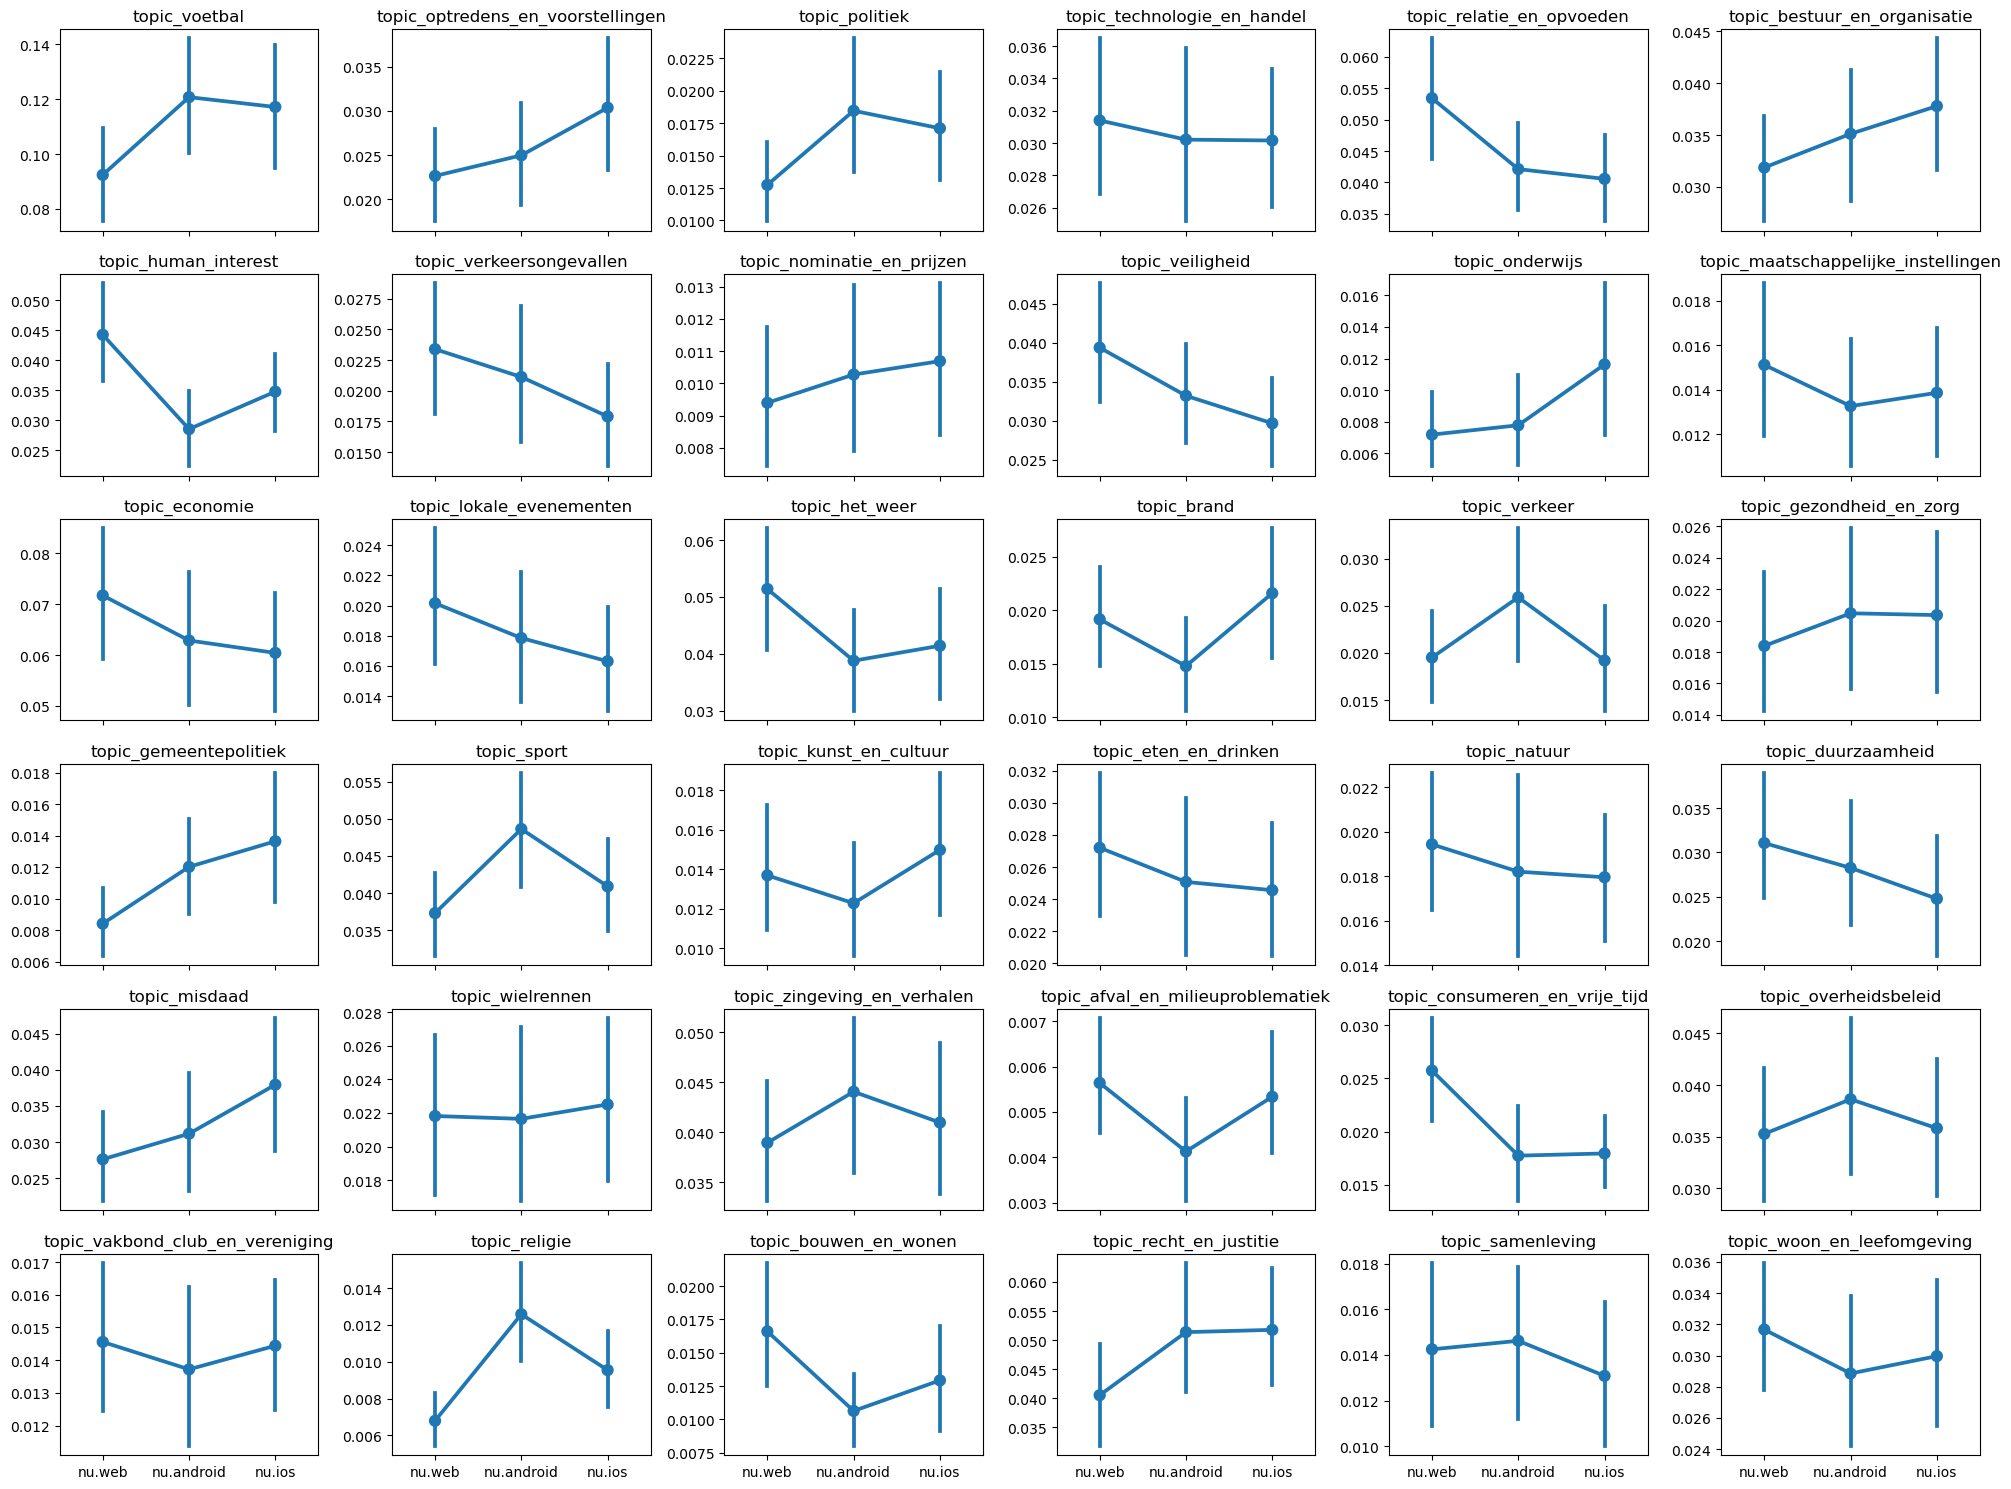

In [22]:
# TODO: Correct the yscales
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged.sample(frac=0.001).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

# Correlation device and topic diversity
Topic diversity has been measured in terms of article entropy. The means of the entropies of articles across device types has been compared. Since it looks like a normal distribution, ANOVA has been applied. It results in a signficant p-value, but a low np2 means a small effect size.
There are no discernible clusters in a 2-dimensional space.


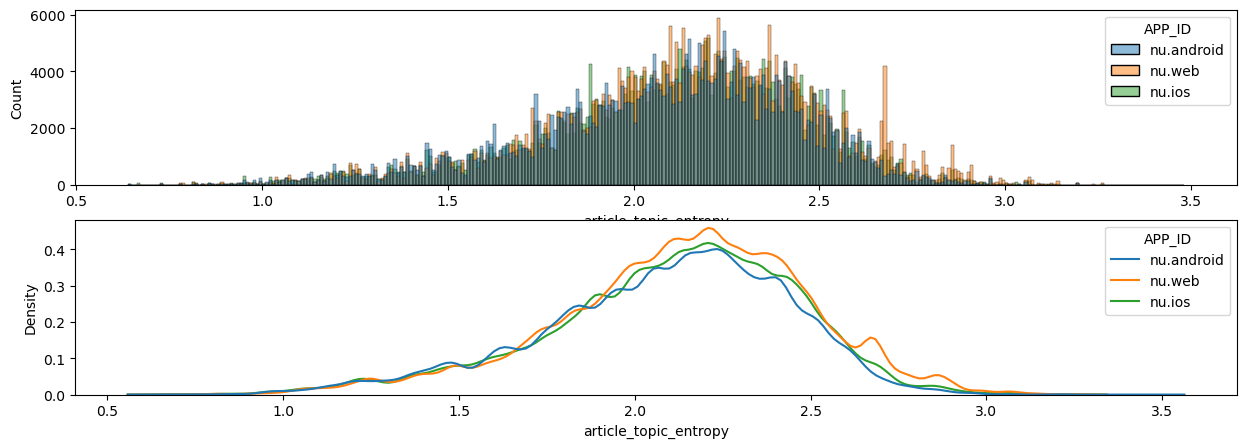

In [23]:
fig, axes = plt.subplots(2,1,figsize=(15, 5))
tmp = ddf_topics_merged.sample(frac=1).compute().reset_index()
sns.histplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[0])
sns.kdeplot(data=tmp, x="article_topic_entropy", hue="APP_ID", ax=axes[1])
plt.show()

In [24]:
# median_fun = pd.Aggregation(
#     name="median",
#     # this computes the median on each partition
#     chunk=lambda s: s.median(),
#     # this combines results across partitions; the input should just be a list of length 1
#     agg=lambda s0: s0.sum(),
# )
ddf_topics_merged[["APP_ID", "article_topic_entropy"]].groupby("APP_ID").agg(["mean", "std", "min", "max"]).compute()

article_topic_entropy                              
                            mean       std       min       max
APP_ID                                                        
nu.android              2.085306  0.348574  0.638017  3.482929
nu.ios                  2.109133  0.352443  0.638017  3.261800
nu.web                  2.137828  0.354462  0.638017  3.261815

In [25]:
tmp = ddf_topics_merged.compute()
pg.anova(data=tmp, dv='article_topic_entropy', between='APP_ID')

/home/bestname/anaconda3/envs/dpg/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()


Source  ddof1    ddof2            F  p-unc       np2
0  APP_ID      2  1182936  2219.073579    0.0  0.003738

<AxesSubplot: xlabel='APP_ID', ylabel='article_topic_entropy'>

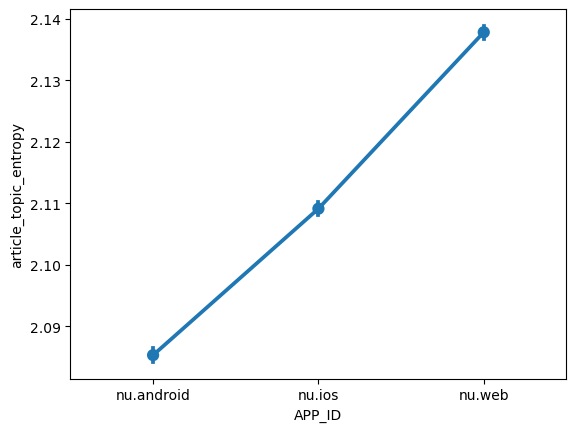

In [26]:
fig, ax = plt.subplots(1,1)
sns.pointplot(data=tmp, x="APP_ID", y='article_topic_entropy', ax=ax)

In [27]:
centroids = ddf_topics_merged[["APP_ID"]+list(topic_columns)].groupby("APP_ID").agg(np.mean).compute()
centroids

topic_voetbal  topic_optredens_en_voorstellingen  topic_politiek  \
APP_ID                                                                         
nu.android       0.121118                           0.027161        0.019768   
nu.ios           0.112582                           0.029047        0.022093   
nu.web           0.084711                           0.027987        0.021500   

            topic_technologie_en_handel  topic_relatie_en_opvoeden  \
APP_ID                                                               
nu.android                     0.029429                   0.045650   
nu.ios                         0.030137                   0.048178   
nu.web                         0.031876                   0.051394   

            topic_bestuur_en_organisatie  topic_human_interest  \
APP_ID                                                           
nu.android                      0.033779              0.033155   
nu.ios                          0.034801              0.035692   
nu.web                          0.032404              0.039221   

            topic_verkeersongevallen  topic_nominatie_en_prijzen  \
APP_ID                                                             
nu.android                  0.022907                    0.009718   
nu.ios                      0.019814                    0.010355   
nu.web                      0.020527                    0.009977   

            topic_veiligheid  ...  topic_zingeving_en_verhalen  \
APP_ID                        ...                                
nu.android          0.031527  ...                     0.038470   
nu.ios              0.030104  ...                     0.041626   
nu.web              0.033267  ...                     0.038539   

            topic_afval_en_milieuproblematiek  topic_consumeren_en_vrije_tijd  \
APP_ID                                                                          
nu.android                           0.005216                        0.020983   
nu.ios                               0.006089                        0.022698   
nu.web                               0.005762                        0.026102   

            topic_overheidsbeleid  topic_vakbond_club_en_vereniging  \
APP_ID                                                                
nu.android               0.038880                          0.014656   
nu.ios                   0.039220                          0.014444   
nu.web                   0.039854                          0.013703   

            topic_religie  topic_bouwen_en_wonen  topic_recht_en_justitie  \
APP_ID                                                                      
nu.android       0.009246               0.013210                 0.048216   
nu.ios           0.009099               0.012274                 0.046883   
nu.web           0.008897               0.013884                 0.046300   

            topic_samenleving  topic_woon_en_leefomgeving  
APP_ID                                                     
nu.android           0.013674                    0.028592  
nu.ios               0.014897                    0.030098  
nu.web               0.017069                    0.031567  

[3 rows x 36 columns]

In [28]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "euclidean"), index=centroids.index, columns=centroids.index)

APP_ID      nu.android    nu.ios    nu.web
APP_ID                                    
nu.android     0.00000  0.012330  0.041280
nu.ios         0.01233  0.000000  0.032025
nu.web         0.04128  0.032025  0.000000

In [29]:
# https://github.com/silviatti/topic-model-diversity
X = centroids.values
pd.DataFrame(cdist(X,X, "cosine"), index=centroids.index, columns=centroids.index)

APP_ID      nu.android        nu.ios    nu.web
APP_ID                                        
nu.android    0.000000  1.663019e-03  0.019391
nu.ios        0.001663  2.220446e-16  0.012077
nu.web        0.019391  1.207708e-02  0.000000

<AxesSubplot: >

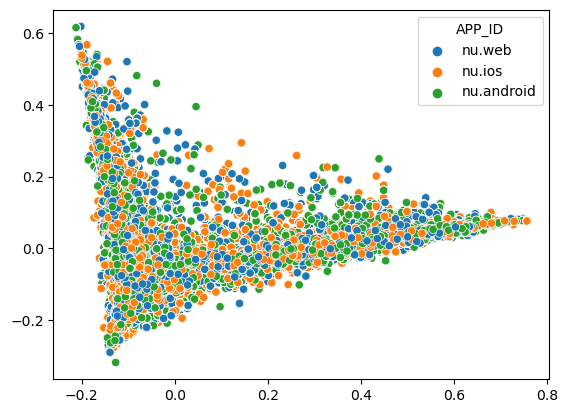

In [30]:
from sklearn.decomposition import PCA
reducer = PCA(2)
data = ddf_topics_merged.sample(frac=1).dropna().compute()
reduced_data = reducer.fit_transform(data[list(topic_columns)])
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], hue=data["APP_ID"])

# Correlation device and USERNEEDS
Kruskal Wallis H reveals a signficant p-value for all the different userneeds across device types

In [31]:
ddf_userneeds = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER_ARTICLES}/reduced_articles_df_fixed_set_userneeds.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
columns_userneeds = ddf_userneeds.columns[ddf_userneeds.columns.str.startswith("userneed_")].values
ddf_userneeds = ddf_userneeds.assign(argmax_userneeds = ddf_userneeds[columns_userneeds].idxmax(axis=1))
ddf_userneeds = ddf_userneeds.set_index('article_id')
ddf_userneeds.head()

userneed_hou_me_op_de_hoogte  userneed_geef_me_context  \
article_id                                                           
537071                          0.282037                  0.224568   
962788                          0.121325                  0.065335   
1013291                         0.132751                  0.059254   
1149251                         0.159672                  0.108233   
1401797                         0.071099                  0.054092   

            userneed_vermaak_me  userneed_raak_me_verbind_me  \
article_id                                                     
537071                 0.279466                     0.030468   
962788                 0.212335                     0.015897   
1013291                0.704135                     0.089935   
1149251                0.444364                     0.015201   
1401797                0.790514                     0.059013   

            userneed_help_me  file_name              argmax_userneeds  
article_id                                                             
537071              0.183461          3  userneed_hou_me_op_de_hoogte  
962788              0.585109          1              userneed_help_me  
1013291             0.013925          2           userneed_vermaak_me  
1149251             0.272529          3           userneed_vermaak_me  
1401797             0.025282          3           userneed_vermaak_me

In [32]:
ddf_userneeds_merged = ddf_userneeds.merge(ddf_views[["APP_ID"]], how="inner", left_index=True, right_index=True)
ddf_userneeds_merged.head()

/home/bestname/anaconda3/envs/dpg/lib/python3.10/site-packages/dask/dataframe/core.py:7722: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [userneed_hou_me_op_de_hoogte, userneed_geef_me_context, userneed_vermaak_me, userneed_raak_me_verbind_me, userneed_help_me, file_name, argmax_userneeds, APP_ID]
Index: []

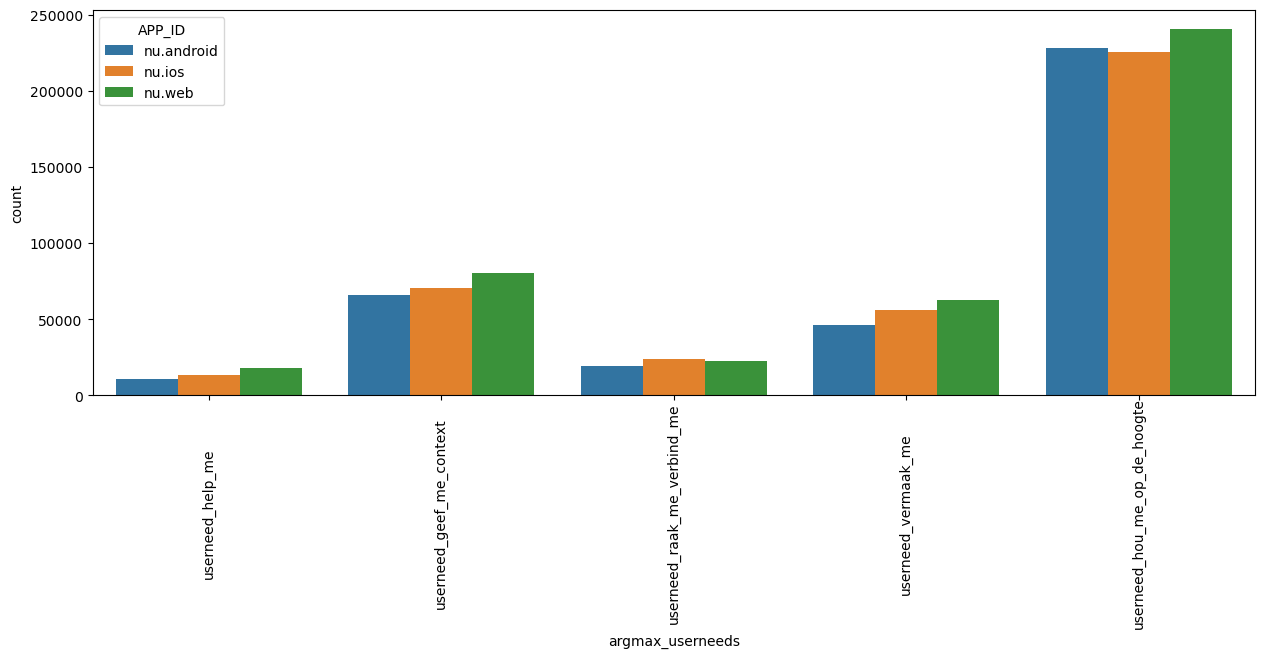

In [33]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
tmp = ddf_userneeds_merged[["argmax_userneeds", "APP_ID"]].compute()
ax = sns.countplot(data=tmp, x="argmax_userneeds", hue="APP_ID", ax=axes)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, va="center", position=(0,-0.28))
plt.show()

In [34]:
l_test_results = list()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need in tqdm.tqdm(columns_userneeds):
    res = {"need": need, **pg.kruskal(data=tmp, dv=need, between="APP_ID").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


need  Source  ddof1           H         p-unc
4              userneed_help_me  APP_ID      2  361.753577  2.793887e-79
0  userneed_hou_me_op_de_hoogte  APP_ID      2  280.005067  1.576421e-61
2           userneed_vermaak_me  APP_ID      2  235.086334  8.946459e-52
3   userneed_raak_me_verbind_me  APP_ID      2  196.516533  2.123132e-43
1      userneed_geef_me_context  APP_ID      2   44.546795  2.122201e-10

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


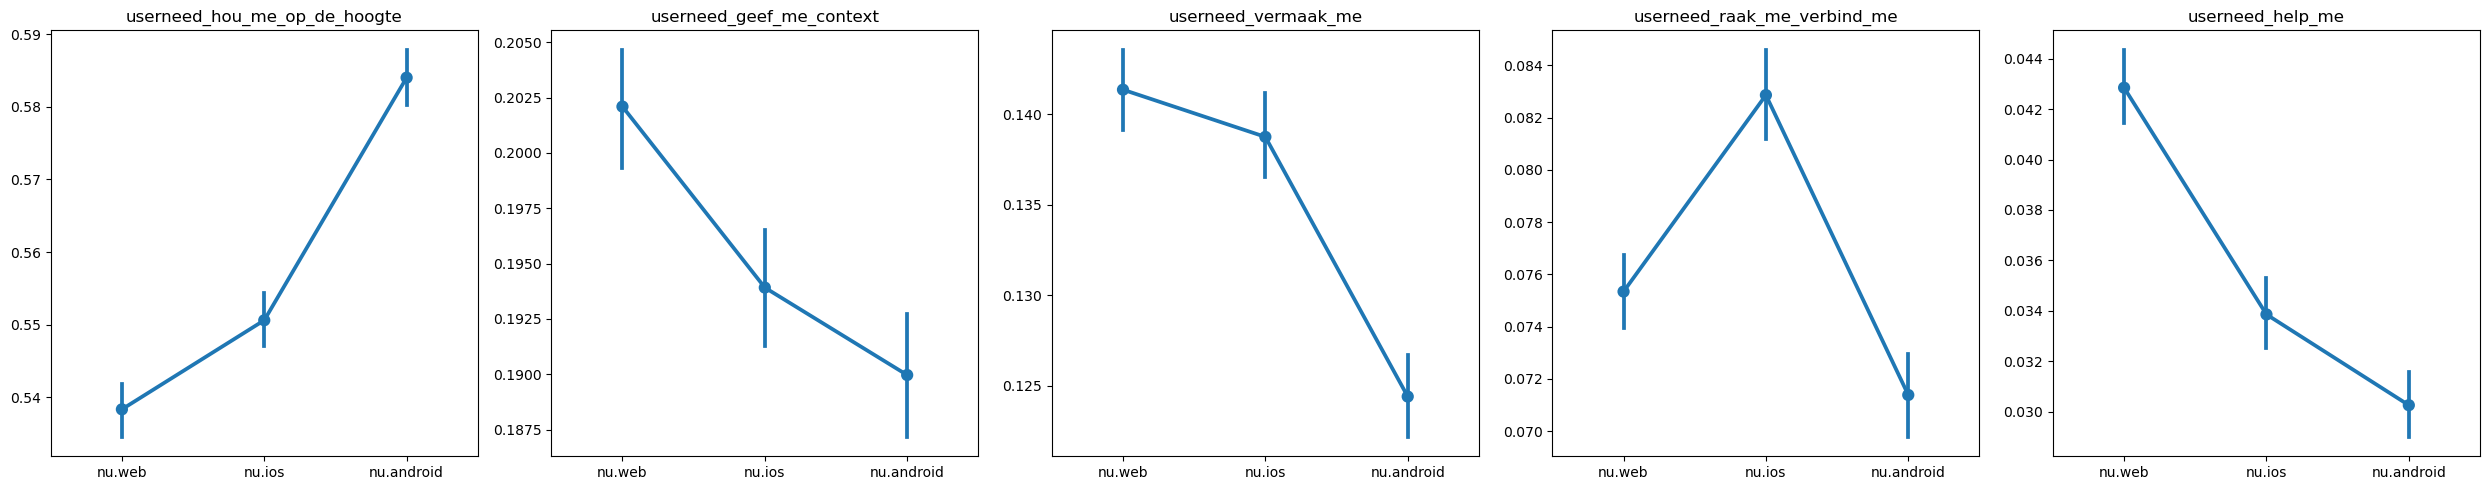

In [35]:
fig, axes = plt.subplots(1, len(columns_userneeds),figsize=(25, 5), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_userneeds_merged.sample(frac=0.1).compute()
for need, ax in tqdm.tqdm(zip(columns_userneeds, faxes), total=len(columns_userneeds)):
    ax = sns.pointplot(data=tmp, x="APP_ID", y=need, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(need)
fig.tight_layout()  
plt.show()

# LOCATION

In [57]:
# https://pypi.org/project/pgeocode/
# https://www.cbs.nl/en-gb/our-services/open-data/statline-as-open-data/cartography
ddf_location = ddf_views[["GEO_CITY","GEO_COUNTRY","GEO_REGION","GEO_ZIPCODE", "APP_ID", "ARTICLE_ID"]].dropna(subset="GEO_ZIPCODE")
ddf_location["article_id"] = ddf_location["ARTICLE_ID"].astype(int)
ddf_location["postal_code"] = ddf_location["GEO_ZIPCODE"]
ddf_location = ddf_location.set_index("postal_code")
display(ddf_location.head())
display(ddf_location)

GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE      APP_ID  \
postal_code                                                            
00-012           2478          PL         14      00-012      nu.web   
00-028           2478          PL         14      00-028  nu.android   
00-180           2478          PL         14      00-180      nu.ios   
00-201           2478          PL         14      00-201      nu.web   
00-202           2478          PL         14      00-202      nu.web   

             ARTICLE_ID  article_id  
postal_code                          
00-012          6226451     6226451  
00-028          6215433     6215433  
00-180          6197338     6197338  
00-201          6208768     6208768  
00-202          6194501     6194501

Dask DataFrame Structure:
              GEO_CITY GEO_COUNTRY GEO_REGION GEO_ZIPCODE  APP_ID ARTICLE_ID article_id
npartitions=3                                                                          
00-012           int64      object     object      object  object      int64      int64
2291               ...         ...        ...         ...     ...        ...        ...
4812               ...         ...        ...         ...     ...        ...        ...
xwk                ...         ...        ...         ...     ...        ...        ...
Dask Name: sort_index, 49 graph layers

In [ ]:
# ddf_location.groupby("APP_ID").agg(lambda df: df["GEO_REGION"].value_counts()).compute()

In [58]:
unique_postal_codes = ddf_location["GEO_ZIPCODE"].unique().compute()
unique_postal_codes.values

In [ ]:
nomi = geo.Nominatim('nl')
all_location_data = nomi.query_postal_code(unique_postal_codes.values).set_index('postal_code').dropna(how="all")
all_location_data.index = all_location_data.index.astype("str")
all_location_data["county_code"] = all_location_data["county_code"].astype("str")
all_location_data

country_code      place_name     state_name  state_code  \
postal_code                                                           
4337                  NL      Middelburg        Zeeland        10.0   
4611                  NL  Bergen op Zoom  Noord-Brabant         6.0   
6718                  NL             Ede     Gelderland         3.0   
7326                  NL       Apeldoorn     Gelderland         3.0   
3769                  NL     Soesterberg        Utrecht         9.0   
...                  ...             ...            ...         ...   
1846                  NL    Zuidschermer  Noord-Holland         7.0   
8856                  NL   Pietersbierum      Friesland         2.0   
8742                  NL        Burgwerd      Friesland         2.0   
7048                  NL      Wijnbergen     Gelderland         3.0   
8361                  NL       IJsselham     Overijssel        15.0   

                 county_name  county_code  community_name  community_code  \
postal_code                                                                 
4337              Middelburg          687             NaN             NaN   
4611          Bergen op Zoom          748             NaN             NaN   
6718                     Ede          228             NaN             NaN   
7326               Apeldoorn          200             NaN             NaN   
3769                   Soest          342             NaN             NaN   
...                      ...          ...             ...             ...   
1846                 Alkmaar          361             NaN             NaN   
8856               Waadhoeke         1949             NaN             NaN   
8742         Súdwest-Fryslân         1900             NaN             NaN   
7048             Montferland         1955             NaN             NaN   
8361         Steenwijkerland         1708             NaN             NaN   

             latitude  longitude  accuracy  
postal_code                                 
4337          51.4896     3.6279       6.0  
4611          51.4950     4.2860       6.0  
6718          52.0529     5.6412       6.0  
7326          52.1953     6.0098       6.0  
3769          52.1190     5.2906       6.0  
...               ...        ...       ...  
1846          52.5803     4.7792       6.0  
8856          53.2134     5.4686       6.0  
8742          53.0883     5.5436       6.0  
7048          51.9340     6.2804       6.0  
8361          52.8109     5.9601       6.0  

[3890 rows x 11 columns]

In [ ]:
# Got data from here! https://www.webuildinternet.com/2015/07/09/geojson-data-of-the-netherlands/
gdf = gpd.read_file('townships.geojson')
gdf["county_code"] = None
gdf["county_code"] = gdf["code"].astype(int)
gdf

code           name           regioFacet  level  \
0    1680    Aa en Hunze  tcm:106-353398-1024      4   
1    0106          Assen  tcm:106-353399-1024      4   
2    1681  Borger-Odoorn  tcm:106-353400-1024      4   
3    0109      Coevorden  tcm:106-353401-1024      4   
4    1690      De Wolden  tcm:106-353402-1024      4   
..    ...            ...                  ...    ...   
389  0707        Zederik  tcm:106-353812-1024      4   
390  0637     Zoetermeer  tcm:106-353813-1024      4   
391  0638    Zoeterwoude  tcm:106-353814-1024      4   
392  1892       Zuidplas  tcm:106-353815-1024      4   
393  0642    Zwijndrecht  tcm:106-353816-1024      4   

                                          url  \
0      /regioinformatie/gemeente/aa-en-hunze/   
1            /regioinformatie/gemeente/assen/   
2    /regioinformatie/gemeente/borger-odoorn/   
3        /regioinformatie/gemeente/coevorden/   
4        /regioinformatie/gemeente/de-wolden/   
..                                        ...   
389        /regioinformatie/gemeente/zederik/   
390     /regioinformatie/gemeente/zoetermeer/   
391    /regioinformatie/gemeente/zoeterwoude/   
392       /regioinformatie/gemeente/zuidplas/   
393    /regioinformatie/gemeente/zwijndrecht/   

                                              geometry  county_code  
0    MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680  
1    MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106  
2    MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681  
3    MULTIPOLYGON (((6.61615 52.76292, 6.66088 52.8...          109  
4    MULTIPOLYGON (((6.27430 52.70619, 6.25312 52.7...         1690  
..                                                 ...          ...  
389  MULTIPOLYGON (((4.99497 51.90229, 4.97341 51.8...          707  
390  MULTIPOLYGON (((4.47237 52.03828, 4.47074 52.0...          637  
391  MULTIPOLYGON (((4.49372 52.12999, 4.51321 52.1...          638  
392  MULTIPOLYGON (((4.59877 51.98797, 4.59437 51.9...         1892  
393  MULTIPOLYGON (((4.56674 51.81283, 4.56118 51.8...          642  

[394 rows x 7 columns]

In [ ]:
ddf_location_full = ddf_location.merge(all_location_data[["county_code","county_name"]])
ddf_location_full

TypeError: '<' not supported between instances of 'str' and 'int'

In [46]:
ddf_location_agg_count = ddf_location_full[["APP_ID", "ARTICLE_ID", "county_code"]].groupby(["county_code", "APP_ID"]).count().compute()
ddf_location_agg_count

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['index']
  Missing: ['GEO_ZIPCODE']

In [ ]:
gdf_device_counts = gdf.merge(ddf_location_agg_count, left_on="county_code", right_on="county_code", how="left")
gdf_device_counts["counts_scaled"] = (gdf_device_counts["ARTICLE_ID"] - gdf_device_counts["ARTICLE_ID"].mean()) / gdf_device_counts["ARTICLE_ID"].std()
gdf_device_counts["counts_logged"] = np.log(gdf_device_counts["ARTICLE_ID"]) 
gdf_device_counts["counts_normed"] = gdf_device_counts[["APP_ID", "counts_logged"]].groupby("APP_ID").transform(lambda df: (df - df.min())/(df.max()-df.min()))
gdf_device_counts.head(10)

code           name           regioFacet  level  \
0  1680    Aa en Hunze  tcm:106-353398-1024      4   
1  1680    Aa en Hunze  tcm:106-353398-1024      4   
2  1680    Aa en Hunze  tcm:106-353398-1024      4   
3  0106          Assen  tcm:106-353399-1024      4   
4  0106          Assen  tcm:106-353399-1024      4   
5  0106          Assen  tcm:106-353399-1024      4   
6  1681  Borger-Odoorn  tcm:106-353400-1024      4   
7  1681  Borger-Odoorn  tcm:106-353400-1024      4   
8  1681  Borger-Odoorn  tcm:106-353400-1024      4   
9  0109      Coevorden  tcm:106-353401-1024      4   

                                        url  \
0    /regioinformatie/gemeente/aa-en-hunze/   
1    /regioinformatie/gemeente/aa-en-hunze/   
2    /regioinformatie/gemeente/aa-en-hunze/   
3          /regioinformatie/gemeente/assen/   
4          /regioinformatie/gemeente/assen/   
5          /regioinformatie/gemeente/assen/   
6  /regioinformatie/gemeente/borger-odoorn/   
7  /regioinformatie/gemeente/borger-odoorn/   
8  /regioinformatie/gemeente/borger-odoorn/   
9      /regioinformatie/gemeente/coevorden/   

                                            geometry  county_code      APP_ID  \
0  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680  nu.android   
1  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680      nu.ios   
2  MULTIPOLYGON (((6.64859 53.02633, 6.64466 53.0...         1680      nu.web   
3  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106  nu.android   
4  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106      nu.ios   
5  MULTIPOLYGON (((6.51304 53.01056, 6.50998 53.0...          106      nu.web   
6  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681  nu.android   
7  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681      nu.ios   
8  MULTIPOLYGON (((6.75179 52.86402, 6.74729 52.8...         1681      nu.web   
9  MULTIPOLYGON (((6.61615 52.76292, 6.66088 52.8...          109  nu.android   

   ARTICLE_ID  counts_scaled  counts_logged  counts_normed  
0       408.0      -0.227834       6.011267       0.468221  
1       523.0      -0.204399       6.259581       0.418121  
2       513.0      -0.206437       6.240276       0.430284  
3      2041.0       0.104944       7.621195       0.646868  
4      2161.0       0.129398       7.678326       0.581967  
5      2812.0       0.262060       7.941651       0.620810  
6       303.0      -0.249231       5.713733       0.435205  
7       290.0      -0.251880       5.669881       0.350019  
8       411.0      -0.227222       6.018593       0.405459  
9       548.0      -0.199304       6.306275       0.500957

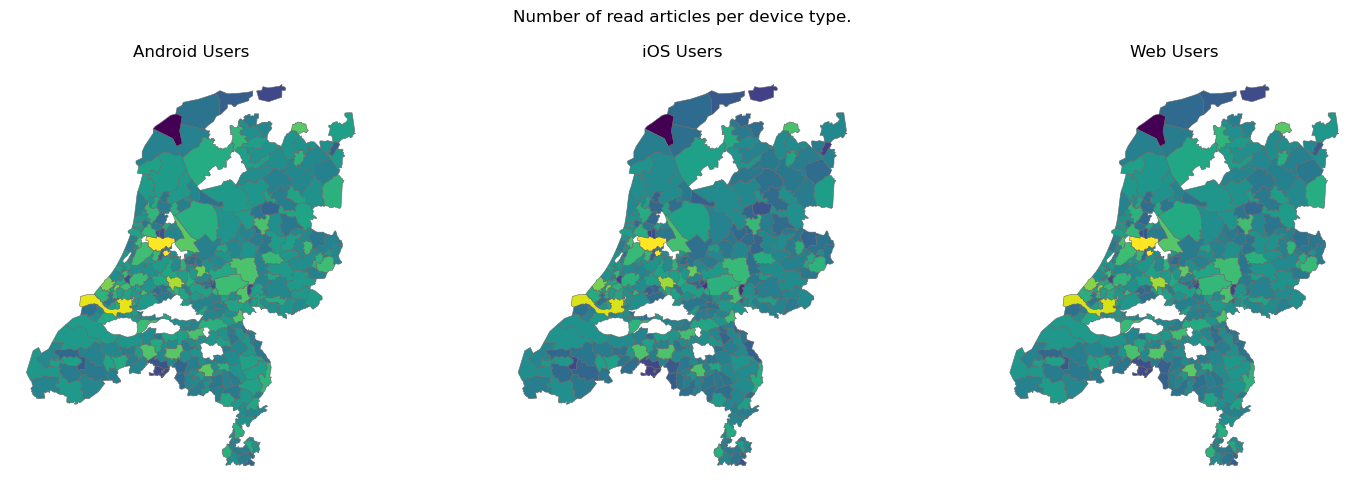

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
# bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=gdf_device_counts["ARTICLE_ID"].min(), vmax=gdf_device_counts["ARTICLE_ID"].max()))
# bar_info._A = []
# cbar = fig.colorbar(bar_info)
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.android"].plot(column="counts_logged", cmap="viridis", linewidth=0.4, ax=axes[0], edgecolor=".4")
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.ios"].plot(column="counts_logged", cmap="viridis", linewidth=0.4, ax=axes[1], edgecolor=".4")
gdf_device_counts[gdf_device_counts["APP_ID"] == "nu.web"].plot(column="counts_logged", cmap="viridis", linewidth=0.4, ax=axes[2], edgecolor=".4")
for ax in axes:
    ax.set_axis_off()
axes[0].set_title("Android Users")    
axes[1].set_title("iOS Users")    
axes[2].set_title("Web Users")    
fig.suptitle("Number of read articles per device type.")    
fig.tight_layout()

In [ ]:
ddf_location_multipurpose = ddf_location_full.merge(ddf_article_filtered, left_index=True, right_index=True)[["county_code", "num_words", "argmax_topic", "article_topic_entropy"]]
ddf_location_multipurpose["county_code"] = ddf_location_multipurpose["county_code"].astype(int)
ddf_location_multipurpose = ddf_location_multipurpose.compute()
ddf_location_multipurpose

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['index']
  Missing: ['GEO_ZIPCODE']

In [ ]:
ddf_location_full.merge(ddf_article_filtered, left_index=True, right_index=True)

Dask DataFrame Structure:
              GEO_ZIPCODE APP_ID_x ARTICLE_ID country_code place_name state_name state_code county_name county_code community_name community_code latitude longitude accuracy article_topic_entropy argmax_topic APP_ID_y num_words num_sentences num_chars
npartitions=9                                                                                                                                                                                                                                              
4536               object   object      int64       object     object     object    float64      object       int64        float64        float64  float64   float64  float64               float64       object   object     int64         int64     int64
537071                ...      ...        ...          ...        ...        ...        ...         ...         ...            ...            ...      ...       ...      ...                   ...          ...      ...       ...           ...       ...
...                   ...      ...        ...          ...        ...        ...        ...         ...         ...            ...            ...      ...       ...      ...                   ...          ...      ...       ...           ...       ...
6227202               ...      ...        ...          ...        ...        ...        ...         ...         ...            ...            ...      ...       ...      ...                   ...          ...      ...       ...           ...       ...
20039404              ...      ...        ...          ...        ...        ...        ...         ...         ...            ...            ...      ...       ...      ...                   ...          ...      ...       ...           ...       ...
Dask Name: join-indexed, 63 graph layers

# INTERACTION

In [ ]:
DATA_FOLDER = "reduced"
ddf_interactions = dd.read_csv(f'data_dpg_testdata/{DATA_FOLDER}/reduced_interactions.csv', dtype={'sub_section': 'object',
       'url': 'object'},)
tmp = ddf_interactions[["ARTICLE_ID","SE_LABEL", "SE_ACTION"]].compute()
unique_interactions_1 = tmp["SE_LABEL"].unique()
unique_interactions_2 = tmp["SE_ACTION"].unique()
ddf_interactions.head()

APP_ID  ARTICLE_ID            DERIVED_TSTAMP      SE_ACTION SE_CATEGORY  \
0  nu.web     6192670  2022-04-01T07:16:48.806Z  post-reaction       nujij   
1  nu.web     6192592  2022-04-01T08:02:14.027Z  post-reaction       nujij   
2  nu.web     6192670  2022-04-01T08:01:27.569Z  post-reaction       nujij   
3  nu.web     6192670  2022-04-01T08:02:12.540Z  post-reaction       nujij   
4  nu.web     6192629  2022-04-01T07:51:56.635Z  post-reaction       nujij   

              SE_LABEL  SE_VALUE                     QUASI_USER_ID  \
0  comment-on-reaction       1.0  780840469334879923dbe38c0e8a2ab3   
1         new-reaction       1.0  5132ce5b0ccb5b3a2f9b2775a99d2ee7   
2  comment-on-reaction       1.0  e9dcaa5ab5e431e1f86a018e92008043   
3         new-reaction       1.0  9fdbeac954e9c98ab8323f6fc2520910   
4  comment-on-reaction       1.0  fc39be4398815482fe41575af63f6587   

   IS_LOGGED_IN  GEO_CITY  ...  privacy_non-personalised_ads  \
0             1        24  ...                             1   
1             1        15  ...                             1   
2             1       303  ...                             1   
3             1        16  ...                             1   
4             1       615  ...                             1   

   privacy_marketing  privacy_social_media  privacy_geo_location  \
0                  1                     1                     0   
1                  1                     1                     0   
2                  1                     1                     0   
3                  1                     1                     0   
4                  1                     1                     0   

   privacy_advertising  file_name  GEO_COUNTRY  GEO_REGION  GEO_ZIPCODE  \
0                    1          0          NaN         NaN          NaN   
1                    1          0           NL          ZH         3079   
2                    1          0           NL          FL         3893   
3                    1          0           NL          ZH         2513   
4                    1          0           BE         VAN         2280   

   REFR_MEDIUM  
0          NaN  
1          NaN  
2     internal  
3          NaN  
4          NaN  

[5 rows x 25 columns]

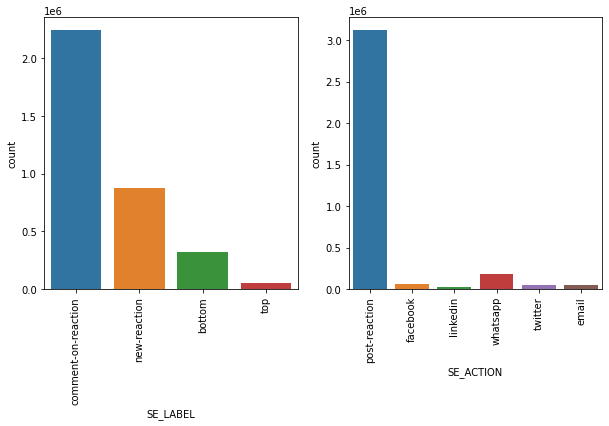

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(data=tmp, x="SE_LABEL", ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
sns.countplot(data=tmp, x="SE_ACTION", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
plt.show()


In [ ]:
ddf_topics_merged_interactions = ddf_topics.merge(ddf_interactions[["ARTICLE_ID", "SE_LABEL", "SE_ACTION"]], how="inner", left_on='article_id', right_on='ARTICLE_ID').persist()
display(ddf_topics_merged_interactions)


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7201: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


Empty DataFrame
Columns: [topic_voetbal, topic_optredens_en_voorstellingen, topic_politiek, topic_technologie_en_handel, topic_relatie_en_opvoeden, topic_bestuur_en_organisatie, topic_human_interest, topic_verkeersongevallen, topic_nominatie_en_prijzen, topic_veiligheid, topic_onderwijs, topic_maatschappelijke_instellingen, topic_economie, topic_lokale_evenementen, topic_het_weer, topic_brand, topic_verkeer, topic_gezondheid_en_zorg, topic_gemeentepolitiek, topic_sport, topic_kunst_en_cultuur, topic_eten_en_drinken, topic_natuur, topic_duurzaamheid, topic_misdaad, topic_wielrennen, topic_zingeving_en_verhalen, topic_afval_en_milieuproblematiek, topic_consumeren_en_vrije_tijd, topic_overheidsbeleid, topic_vakbond_club_en_vereniging, topic_religie, topic_bouwen_en_wonen, topic_recht_en_justitie, topic_samenleving, topic_woon_en_leefomgeving, file_name, article_topic_entropy, argmax_topic, APP_ID]
Index: []

[0 rows x 40 columns]

4it [00:03,  1.15it/s]


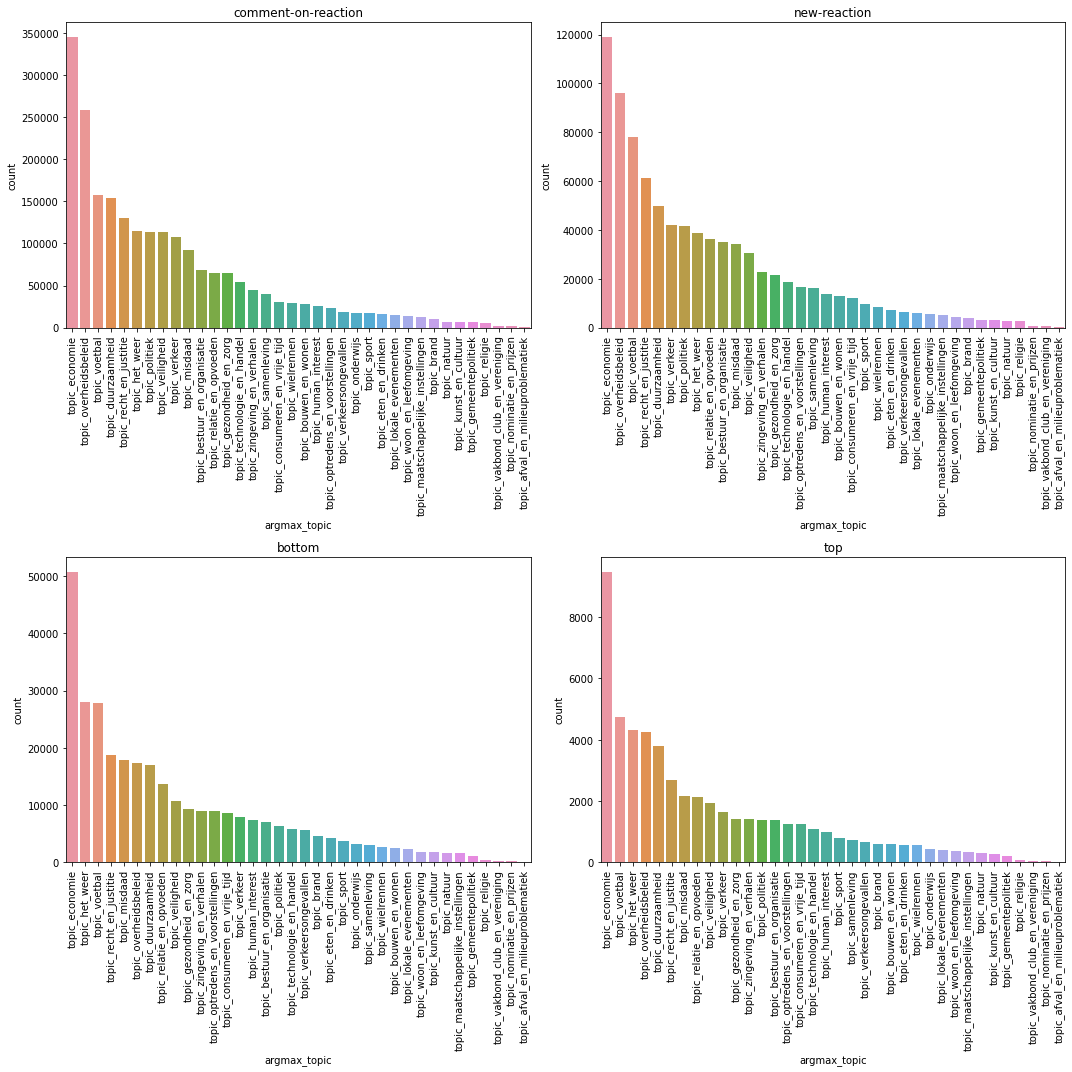

In [ ]:
fig, axes = plt.subplots(2,(len(unique_interactions_1)//2), figsize=(15, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_LABEL"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_1, faxes)):
    order = tmp.loc[tmp["SE_LABEL"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_LABEL"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

6it [00:04,  1.36it/s]


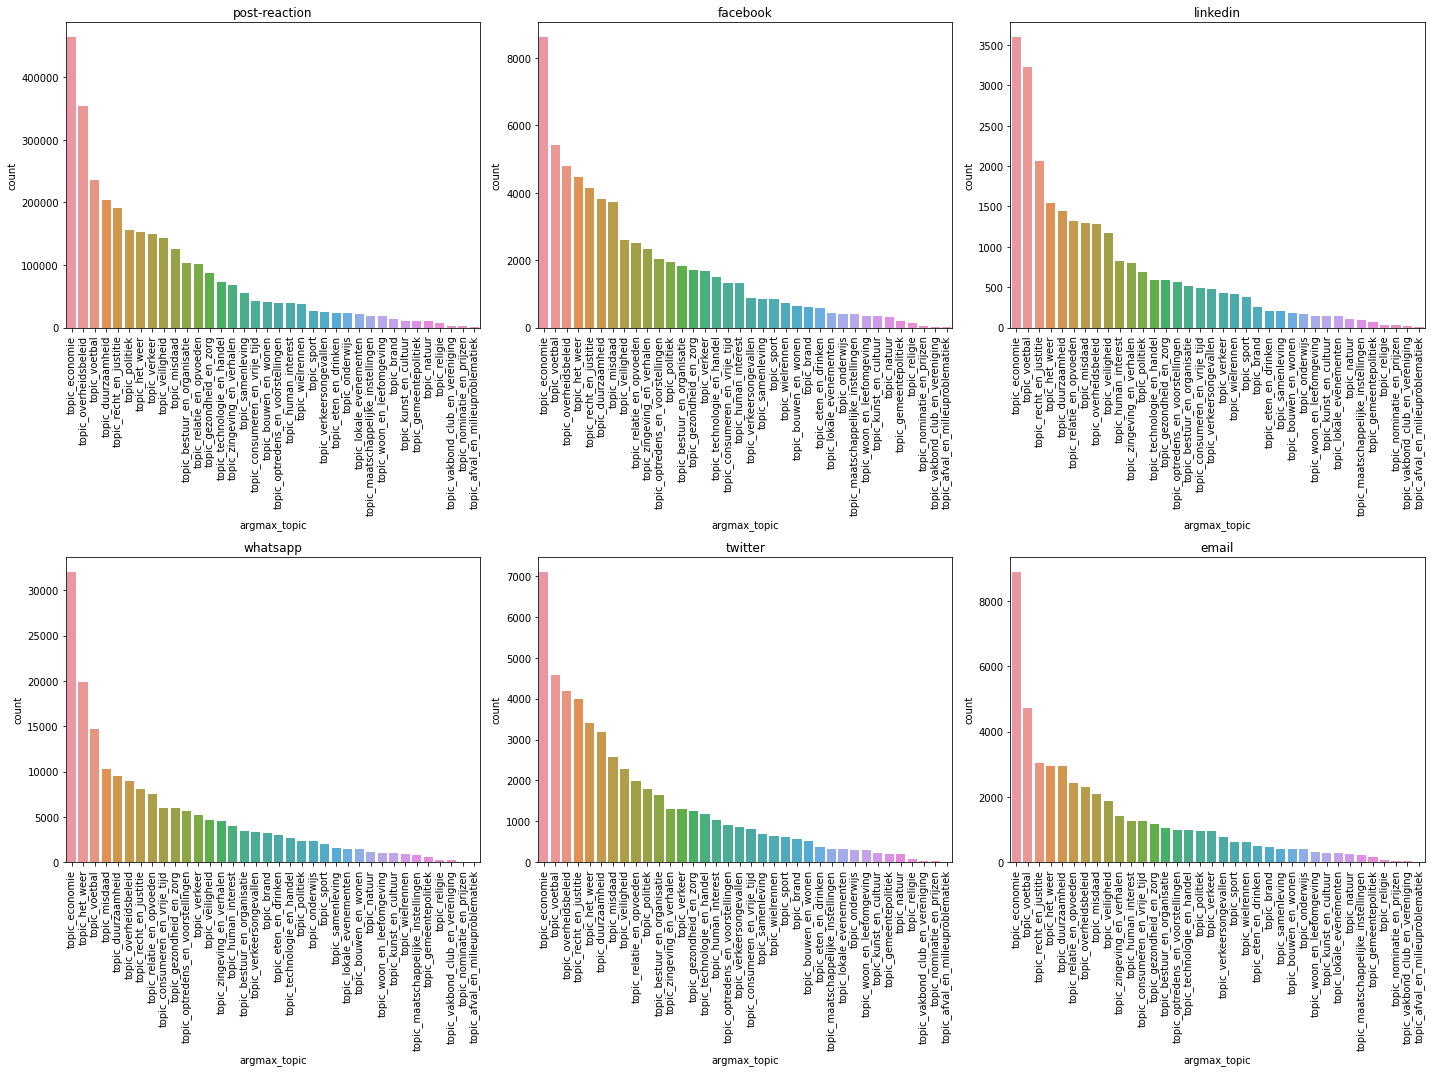

In [ ]:
fig, axes = plt.subplots(2,(len(unique_interactions_2)//2), figsize=(20, 15))
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[["argmax_topic", "SE_ACTION"]].compute()
for interaction, ax in tqdm.tqdm(zip(unique_interactions_2, faxes)):
    order = tmp.loc[tmp["SE_ACTION"]==interaction]["argmax_topic"].value_counts().index
    ax = sns.countplot(data=tmp.loc[tmp["SE_ACTION"]==interaction], x="argmax_topic", ax=ax, order=order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(interaction)
fig.tight_layout()
plt.show()

In [ ]:
l_test_results = list()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic in tqdm.tqdm(topic_columns):
    res = {"topic": topic, **pg.kruskal(data=tmp, dv=topic, between="SE_LABEL").iloc[0].to_dict()}
    l_test_results.append(res)
df_test_results = pd.DataFrame(l_test_results).sort_values("p-unc")
df_test_results

100%|██████████| 36/36 [00:00<00:00, 65.75it/s]


topic    Source  ddof1           H  \
29                topic_overheidsbeleid  SE_LABEL      3  240.657766   
6                  topic_human_interest  SE_LABEL      3  147.339482   
7              topic_verkeersongevallen  SE_LABEL      3  110.376908   
17             topic_gezondheid_en_zorg  SE_LABEL      3  107.024381   
20               topic_kunst_en_cultuur  SE_LABEL      3   98.728125   
2                        topic_politiek  SE_LABEL      3   97.597878   
0                         topic_voetbal  SE_LABEL      3   91.248555   
14                       topic_het_weer  SE_LABEL      3   79.432707   
23                   topic_duurzaamheid  SE_LABEL      3   78.678388   
1     topic_optredens_en_voorstellingen  SE_LABEL      3   74.606139   
28       topic_consumeren_en_vrije_tijd  SE_LABEL      3   73.306305   
4             topic_relatie_en_opvoeden  SE_LABEL      3   68.751152   
26          topic_zingeving_en_verhalen  SE_LABEL      3   63.870516   
21                topic_eten_en_drinken  SE_LABEL      3   59.764352   
22                         topic_natuur  SE_LABEL      3   54.917513   
35           topic_woon_en_leefomgeving  SE_LABEL      3   49.397377   
19                          topic_sport  SE_LABEL      3   48.996966   
12                       topic_economie  SE_LABEL      3   45.503046   
13             topic_lokale_evenementen  SE_LABEL      3   39.870525   
9                      topic_veiligheid  SE_LABEL      3   38.894634   
3           topic_technologie_en_handel  SE_LABEL      3   34.306563   
5          topic_bestuur_en_organisatie  SE_LABEL      3   32.693618   
8            topic_nominatie_en_prijzen  SE_LABEL      3   30.867479   
25                     topic_wielrennen  SE_LABEL      3   25.794463   
30     topic_vakbond_club_en_vereniging  SE_LABEL      3   23.239884   
27    topic_afval_en_milieuproblematiek  SE_LABEL      3   22.317877   
24                        topic_misdaad  SE_LABEL      3   21.386553   
33              topic_recht_en_justitie  SE_LABEL      3   20.962447   
32                topic_bouwen_en_wonen  SE_LABEL      3   20.851861   
31                        topic_religie  SE_LABEL      3   18.461673   
10                      topic_onderwijs  SE_LABEL      3   14.205593   
18               topic_gemeentepolitiek  SE_LABEL      3   10.739295   
34                    topic_samenleving  SE_LABEL      3    7.043703   
15                          topic_brand  SE_LABEL      3    6.194175   
16                        topic_verkeer  SE_LABEL      3    3.689078   
11  topic_maatschappelijke_instellingen  SE_LABEL      3    3.220550   

           p-unc  
29  6.859044e-52  
6   9.877699e-32  
7   9.103755e-24  
17  4.793303e-23  
20  2.917121e-21  
2   5.104272e-21  
0   1.181312e-19  
14  4.061761e-17  
23  5.895100e-17  
1   4.400667e-16  
28  8.357119e-16  
4   7.900262e-15  
26  8.748440e-14  
21  6.600694e-13  
22  7.150094e-12  
35  1.073562e-10  
19  1.306398e-10  
12  7.233480e-10  
13  1.135014e-08  
9   1.827201e-08  
3   1.706869e-07  
5   3.737357e-07  
8   9.064520e-07  
25  1.053073e-05  
30  3.599053e-05  
27  5.601377e-05  
24  8.750292e-05  
33  1.071837e-04  
32  1.130031e-04  
31  3.532079e-04  
10  2.638252e-03  
18  1.322246e-02  
34  7.051777e-02  
15  1.025360e-01  
16  2.970545e-01  
11  3.588545e-01

100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


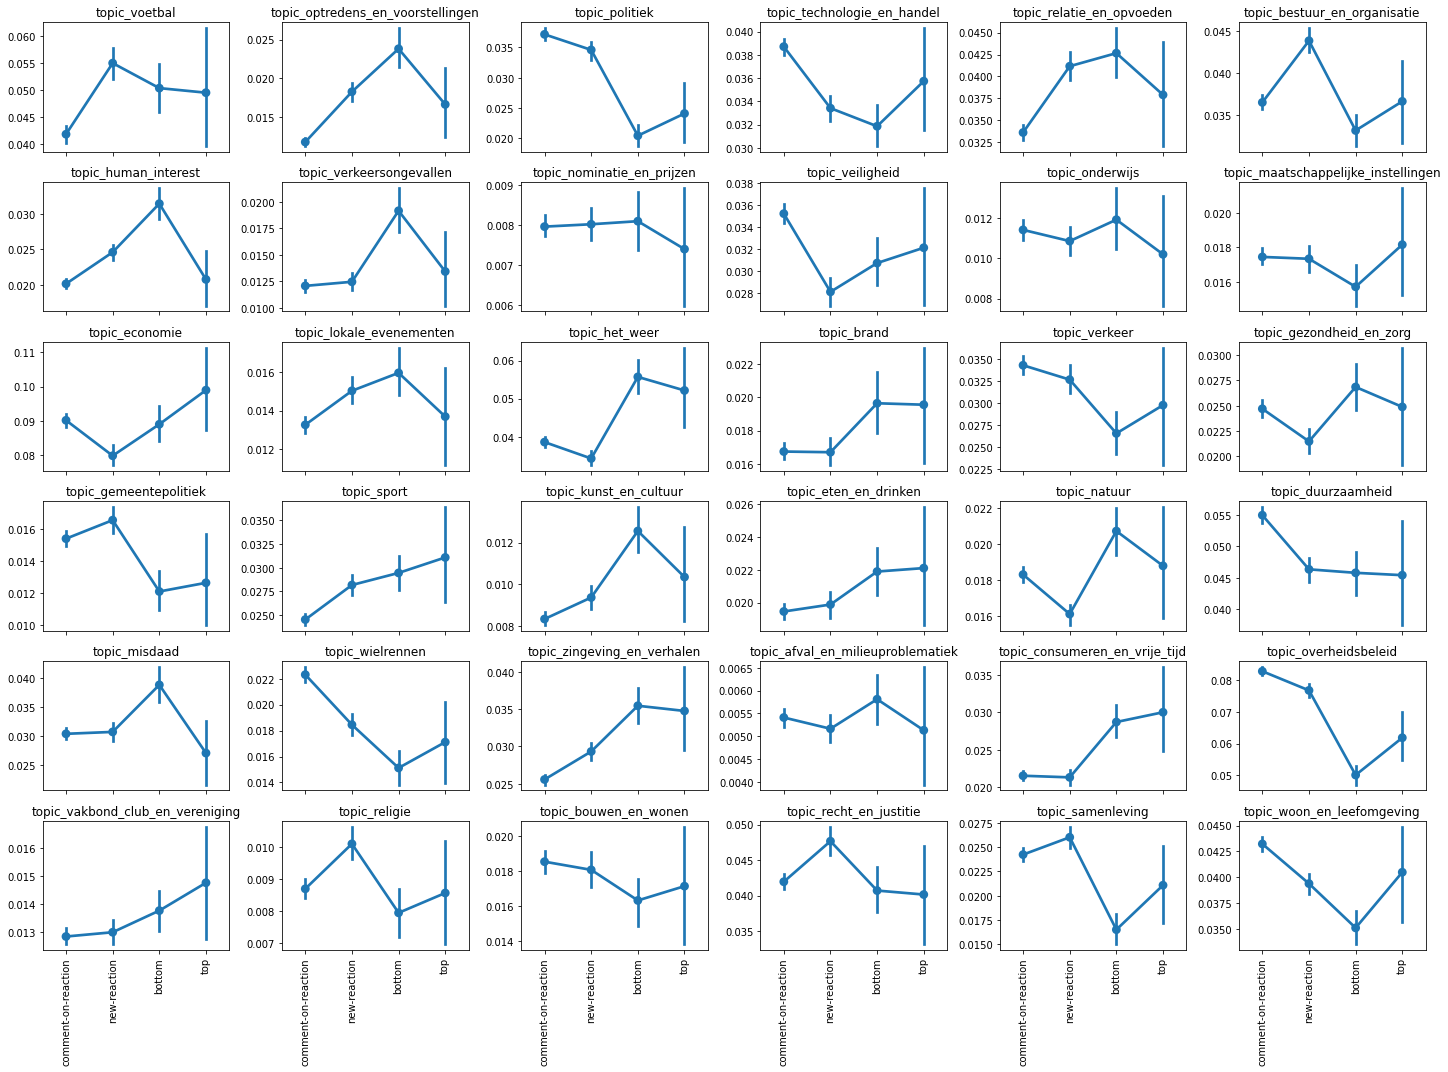

In [ ]:
# TODO: Change the scale so it's not shared between the plots
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions.sample(frac=0.01).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_LABEL", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()

100%|██████████| 36/36 [01:44<00:00,  2.89s/it]


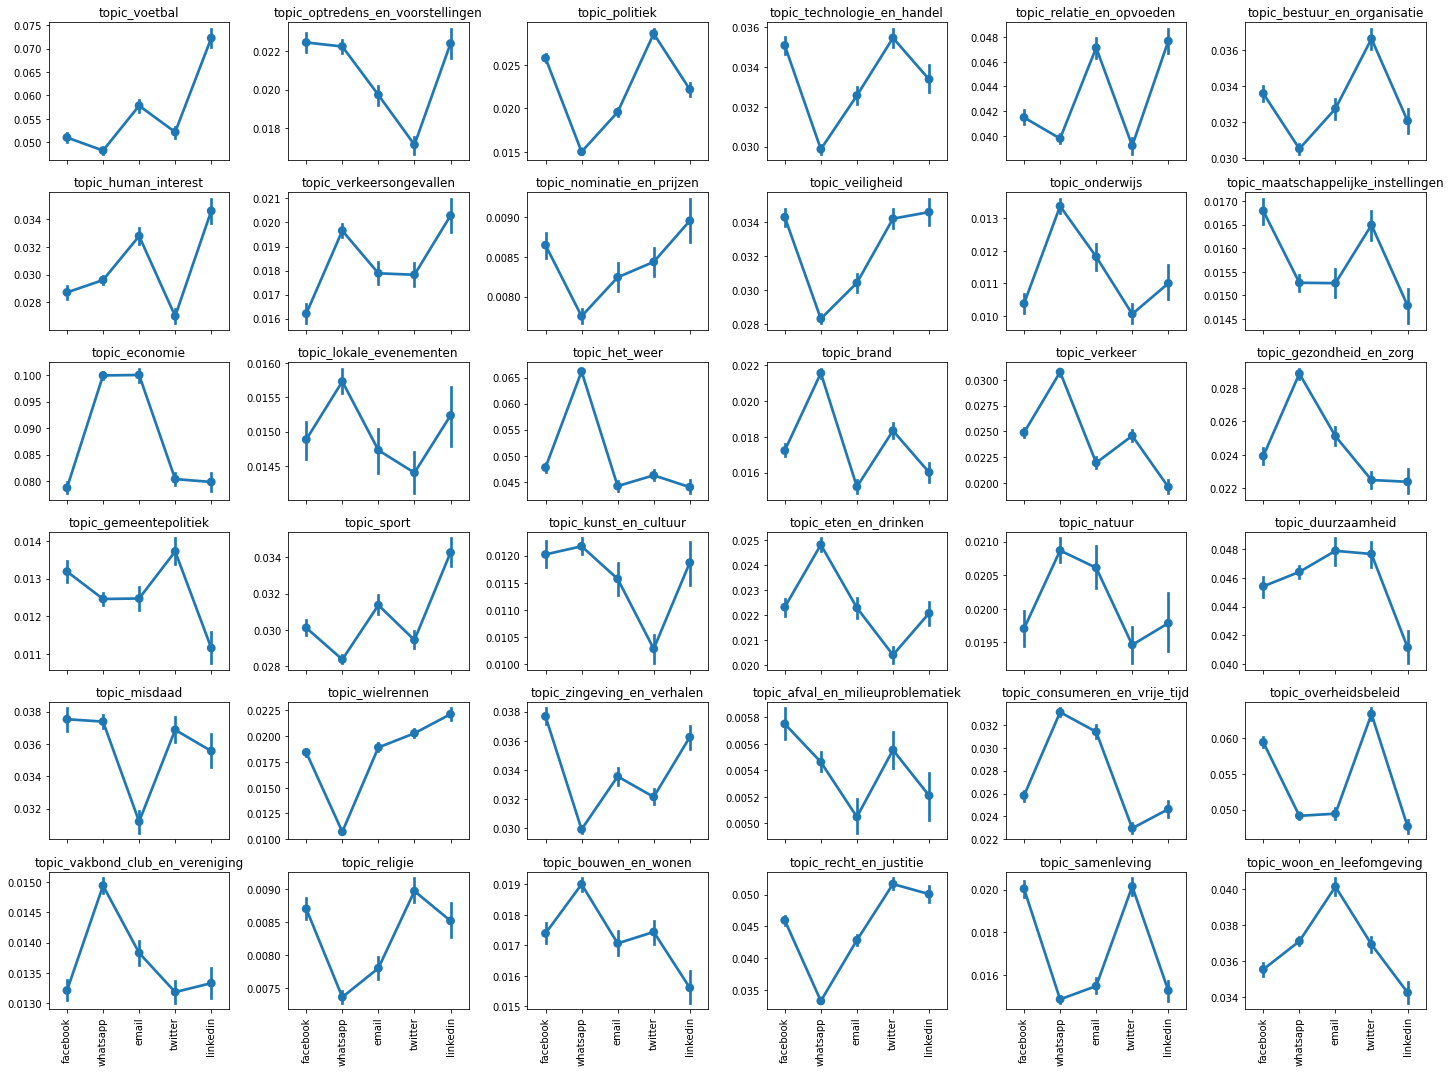

In [ ]:
fig, axes = plt.subplots(6,6,figsize=(20, 15), sharey=False, sharex=True)
faxes = axes.flatten()
tmp = ddf_topics_merged_interactions[ddf_topics_merged_interactions["SE_ACTION"] != "post-reaction"].sample(frac=1).compute()
for topic, ax in tqdm.tqdm(zip(topic_columns, faxes), total=len(topic_columns)):
    ax = sns.pointplot(data=tmp, x="SE_ACTION", y=topic, ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="center")
    ax.set_title(topic)
fig.tight_layout()  
plt.show()